# Предсказание  тяжести ДТП в Москве и области: модели

In [5]:
import warnings
warnings.simplefilter('ignore')

In [6]:
import calendar
import folium

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
sns.set(style="darkgrid", palette='flare')

## Подготовка данных

In [8]:
df = pd.read_csv('dtp_msc.csv')
print(f'Объектов изначально: {df.shape[0]}')
print(f'Признаков изначально: {df.shape[1]}')

Объектов изначально: 88566
Признаков изначально: 58


In [9]:
df.head()

,Unnamed: 0,RTA type,date,traffic changes info,COORD_L,COORD_W,road significance,factors influenced traffic,street significance,RTA road km,...,any cyclists,any concomitant traffic violations,any injuries without safety belt,any child restraints,number of guilty objects,fatal traffic violation(s),number of fatal traffic violations,bodily harm,guilty drivers average experience,drivers average experience
0,0,Столкновение,31.01.2015,Режим движения не изменялся,37.274722,55.739444,Не указано,Сведения отсутствуют,Магистральные дороги,0.0,...,0,0,0,0,1,{'Несоответствие скорости конкретным условиям ...,1,"{'Раненый, находящийся (находившийся) на амбу...",4.0,4.0
1,1,Наезд на препятствие,31.01.2015,Режим движения не изменялся,37.701389,55.734444,Не указано,Сведения отсутствуют,Магистральные улицы районного значения,31.0,...,0,0,0,0,1,{'Несоответствие скорости конкретным условиям ...,1,"{'Раненый, находящийся (находившийся) на амбу...",0.0,0.0
2,2,Столкновение,31.01.2015,Режим движения не изменялся,37.630000,55.801944,Не указано,Сведения отсутствуют,Улицы и дороги местного значения в жилой застр...,0.0,...,0,1,0,0,1,{'Несоблюдение очередности проезда'},1,"{'Раненый, находящийся (находившийся) на амбу...",14.0,8.5
3,3,Столкновение,31.01.2015,Движение частично перекрыто,36.933056,55.464444,Иная дорога,Сведения отсутствуют,Вне НП,0.0,...,0,0,0,0,1,{'Нарушение требований дорожных знаков'},1,"{'Раненый, находящийся (находившийся) на амбу...",1.0,8.5
4,4,Наезд на пешехода,31.01.2015,Режим движения не изменялся,37.610833,55.770000,Не указано,Сведения отсутствуют,Магистральные улицы общегородского значения,0.0,...,0,0,0,0,1,{'Нарушение правил проезда пешеходного перехода'},1,"{'Раненый, находящийся (находившийся) на амбу...",12.0,12.0


In [10]:
df.columns

Index(['Unnamed: 0', 'RTA type', 'date', 'traffic changes info', 'COORD_L',
       'COORD_W', 'road significance', 'factors influenced traffic',
       'street significance', 'RTA road km', 'RTA road m',
       'road network maintenance defects', 'RTA-adjacent road objects',
       'lighting', 's_dtp', 'road surface condition', 'RTA site road objects',
       'weather', 'RTA vehicle number', 'RTA participants number',
       'RTA number', 'number of deaths', 'number of wounded', 'RTA time',
       'any TV technical failures', 'any non-private vehicles',
       'any russian vehicles', 'any vehicles older than 1990',
       'any vehicles older than 2000', 'any vehicles older than 2010',
       'any white vehicles', 'any black vehicles', 'any colored vehicles',
       'any front-wheel-drive vehicles', 'any rear-wheel-drive vehicles',
       'any four-wheel-drive vehicles', 'any A-class vehicles',
       'any B-class vehicles', 'any C-class vehicles', 'any D-class vehicles',
       'any E-

**Новые признаки:**
- день недели
- месяц
- год
- час в сутках
- наш таргет

In [11]:
year = df['date'].astype(str).str[6:10]
hour = df['RTA time'].astype(str).str[:2]
weekday = df.astype({'date' : 'datetime64[ns]'})['date'].apply(lambda x: calendar.day_name[x.weekday()])
month = df.astype({'date' : 'datetime64[ns]'})['date'].apply(lambda x: calendar.month_name[x.month])
target = (df['number of deaths'] != 0).astype('int64')
df.insert(58, 'weekday', weekday)
df.insert(59, 'month', month)
df.insert(60, 'year', year)
df.insert(61, 'hour', hour)
df.insert(62, 'target', target)

**Сохраняем только те признаки, которые могут быть собраны сразу на момент ДТП (руководствуемся здравым смыслом)**

In [12]:
df.drop(columns=['date', 
                  'RTA time', 
                  'number of deaths', 
                  'Unnamed: 0', 
                  'RTA number', 
                  's_dtp', 
                  'RTA road km', 
                  'bodily harm', 
                  'number of wounded', 
                  'RTA vehicle number', 
                  'traffic changes info', 
                  'fatal traffic violation(s)',
                  'number of fatal traffic violations', 
                  'any injuries without safety belt',
                  'any non-private vehicles',
                  'any vehicles older than 1990',
                  'any vehicles older than 2000',
                  'any vehicles older than 2010',
                  'any front-wheel-drive vehicles',
                  'any rear-wheel-drive vehicles',
                  'any four-wheel-drive vehicles',
                  'any drunk passengers',
                  'any drunk drivers',
                  'any female drivers',
                  'any concomitant traffic violations',
                  'any TV technical failures',
                  'any child restraints'], inplace=True)

categorical = ['RTA type', 
               'road significance', 
               'factors influenced traffic',
               'street significance',
               'road network maintenance defects', 
               'RTA-adjacent road objects',
               'lighting',  
               'road surface condition', 
               'RTA site road objects',
               'weather',
               'weekday', 
               'month', 
               'year', 
               'hour']
numerical = ['RTA road m',
             'RTA participants number',
             'number of guilty objects', 
             'guilty drivers average experience',
             'drivers average experience',
             'COORD_L',
             'COORD_W']

**Проверяем числовые переменные на странные выбросы (см. опыт водителей)....**

In [13]:
df[numerical].describe()

,RTA road m,RTA participants number,number of guilty objects,guilty drivers average experience,drivers average experience
count,88566.000000,88566.000000,88566.000000,88566.000000,88566.000000
mean,77.973455,2.431260,1.026895,18.687600,18.950034
std,211.268560,0.879065,0.167336,22.885981,18.702639
min,0.000000,1.000000,1.000000,0.000000,0.000000
25%,0.000000,2.000000,1.000000,5.000000,8.000000
50%,0.000000,2.000000,1.000000,12.000000,13.666667
75%,0.000000,3.000000,1.000000,22.000000,22.000000
max,999.000000,9.000000,5.000000,198.000000,194.000000


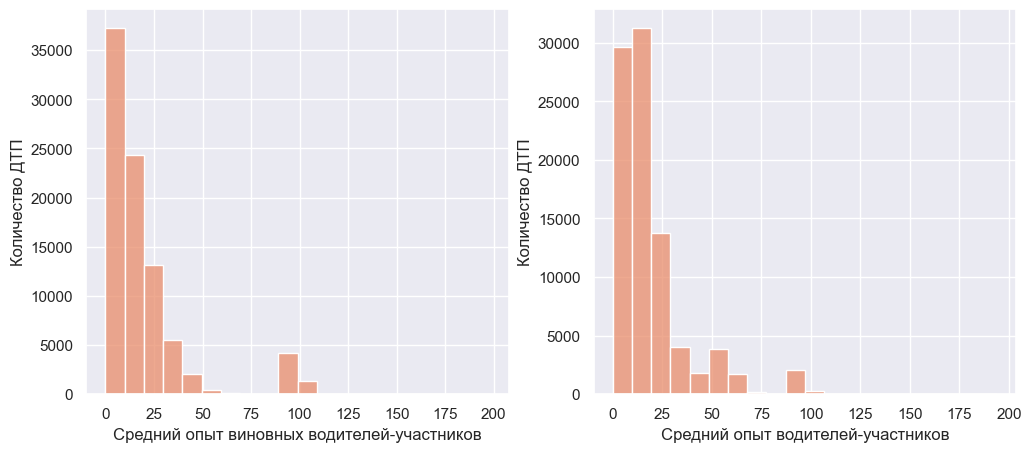

In [14]:
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
sns.histplot(df['guilty drivers average experience'], bins=20)
plt.xlabel('Средний опыт виновных водителей-участников')
plt.ylabel('Количество ДТП');

plt.subplot(1, 2, 2)
sns.histplot(df['drivers average experience'], bins=20)
plt.xlabel('Средний опыт водителей-участников')
plt.ylabel('Количество ДТП');

In [15]:
print(f'Mean average expirience (guilty): {df["guilty drivers average experience"].mean()}')
print(f'Max average expirience (guilty): {df["guilty drivers average experience"].max()}')
print(f'Mean average expirience (all): {df["drivers average experience"].mean()}')
print(f'Max average expirience (all): {df["guilty drivers average experience"].mean()}')

Mean average expirience (guilty): 18.68760020775467
Max average expirience (guilty): 198.0
Mean average expirience (all): 18.950034437594564
Max average expirience (all): 18.68760020775467


**Обрезаем опыт разумной эвристикой, чистим одну из координат от точек**

In [17]:
df = df[df['guilty drivers average experience'] <= 60]
df = df[df['drivers average experience'] <= 60]

df = df[df['COORD_L'] != '.']

print(f'Объектов после обработки: {df.shape[0]}')

Объектов после обработки: 82177


**На всякий случай смотрим пропуски**

In [18]:
df.isna().sum()

RTA type                             0
COORD_L                              0
COORD_W                              0
road significance                    0
factors influenced traffic           0
street significance                  0
RTA road m                           0
road network maintenance defects     0
RTA-adjacent road objects            0
lighting                             0
road surface condition               0
RTA site road objects                0
weather                              0
RTA participants number              0
any russian vehicles                 0
any white vehicles                   0
any black vehicles                   0
any colored vehicles                 0
any A-class vehicles                 0
any B-class vehicles                 0
any C-class vehicles                 0
any D-class vehicles                 0
any E-class vehicles                 0
any S-class vehicles                 0
any non-car vehicles                 0
any escaped participants 

## Подготовка данных и обучение моделей

In [19]:
import optuna

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_auc_score, cohen_kappa_score, matthews_corrcoef, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import IsolationForest

from catboost import CatBoostClassifier

from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE, KMeansSMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, NearMiss, ClusterCentroids

from optuna.trial import Trial

**Смотрим, не нужно ли логарифмировать опыт водителей**

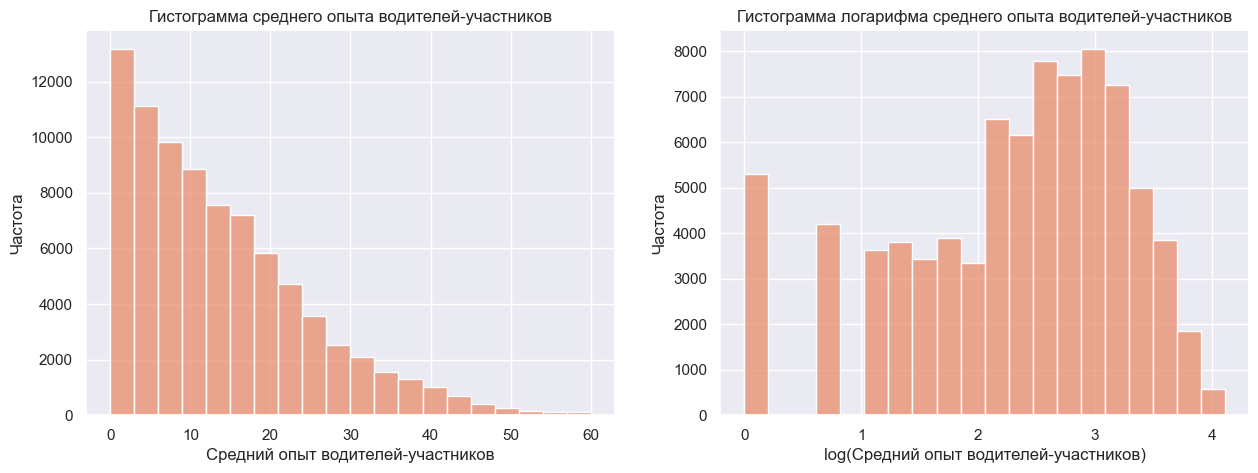

In [20]:
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
sns.histplot(df['guilty drivers average experience'], bins=20);
plt.xlabel('Средний опыт водителей-участников')
plt.ylabel('Частота')
plt.title('Гистограмма среднего опыта водителей-участников');

plt.subplot(1, 2, 2)
sns.histplot(np.log1p(df['guilty drivers average experience']), bins=20);
plt.xlabel('log(Средний опыт водителей-участников)')
plt.ylabel('Частота')
plt.title('Гистограмма логарифма среднего опыта водителей-участников');

In [21]:
df.columns

Index(['RTA type', 'COORD_L', 'COORD_W', 'road significance',
       'factors influenced traffic', 'street significance', 'RTA road m',
       'road network maintenance defects', 'RTA-adjacent road objects',
       'lighting', 'road surface condition', 'RTA site road objects',
       'weather', 'RTA participants number', 'any russian vehicles',
       'any white vehicles', 'any black vehicles', 'any colored vehicles',
       'any A-class vehicles', 'any B-class vehicles', 'any C-class vehicles',
       'any D-class vehicles', 'any E-class vehicles', 'any S-class vehicles',
       'any non-car vehicles', 'any escaped participants', 'any pedestrians',
       'any cyclists', 'number of guilty objects',
       'guilty drivers average experience', 'drivers average experience',
       'weekday', 'month', 'year', 'hour', 'target'],
      dtype='object')

In [22]:
x = df.drop('target', axis=1)
y = df['target']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=69) 

col_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical), 
    ('scaling', StandardScaler(), numerical)],
    remainder='passthrough')

x_tr = col_transformer.fit_transform(x_train)
x_ts = col_transformer.transform(x_test)

x_tr = pd.DataFrame.sparse.from_spmatrix(x_tr)
x_ts = pd.DataFrame.sparse.from_spmatrix(x_ts)

opt_x_train, opt_x_val, opt_y_train, opt_y_val = train_test_split(x_tr, y_train, test_size=0.3)

**Данные очень несбалансированные:**

In [23]:
print(f'Доля единиц: {y.value_counts()[1] / len(y) * 100:.2f}%')

Доля единиц: 5.42%


**Формируем табличку для метрик и пишем функцию для подсчета:**

In [82]:
final = {
    'ROC-AUC' : [],
    'Precision' : [],
    'Recall' : [],
    'F1' : [],
    'Cohen Kappa score' : [],
    'Matthews coef' : []
}

def metrics(test, model):
    probs = model.predict_proba(test)[:, 1]
    preds = model.predict(test)
    return {
        'ROC-AUC' : roc_auc_score(y_test, probs),
        'Precision' : precision_score(y_test, preds),
        'Recall' : recall_score(y_test, preds),
        'F1' : f1_score(y_test, preds),
        'Cohen Kappa score' : cohen_kappa_score(y_test, preds),
        'Matthews coef' : matthews_corrcoef(y_test, preds),
    }

### Логрег + GridSearchSV

In [83]:
logreg = LogisticRegression()
logreg.fit(x_tr, y_train)

res = metrics(x_ts, logreg)
for metric in res:
    final[metric].append(res[metric])

print(f'ROC-AUC: {res['ROC-AUC']}')
print(f'Precision: {res['Precision']}')
print(f'Recall: {res['Recall']}')
print(f'F1: {res['F1']}')
print(f'Cohen Kappa score = {res['Cohen Kappa score']}')
print(f'Matthews coef = {res['Matthews coef']}')

ROC-AUC: 0.7562530781995389
Precision: 0.3902439024390244
Recall: 0.014349775784753363
F1: 0.02768166089965398
Cohen Kappa score = 0.023924080006458515
Matthews coef = 0.06631458399687742


**GridSearch, оптимизируем F1**

In [84]:
logreg = LogisticRegression()
params = {'penalty': ['l1','l2'], 
          'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
          }
searcher = GridSearchCV(logreg, params, scoring='f1')
searcher.fit(x_tr, y_train)
best = searcher.best_params_

logreg = LogisticRegression(**best)
logreg.fit(x_tr, y_train)
res = metrics(x_ts, logreg)
for metric in res:
    final[metric].append(res[metric])

print(f'ROC-AUC: {res['ROC-AUC']}')
print(f'Precision: {res['Precision']}')
print(f'Recall: {res['Recall']}')
print(f'F1: {res['F1']}')
print(f'Cohen Kappa score = {res['Cohen Kappa score']}')
print(f'Matthews coef = {res['Matthews coef']}')

ROC-AUC: 0.7560268550551711
Precision: 0.40476190476190477
Recall: 0.015246636771300448
F1: 0.029386343993085567
Cohen Kappa score = 0.02554683561892912
Matthews coef = 0.07002044466834928


**GridSearch, оптимизируем recall**

In [85]:
logreg = LogisticRegression()
params = {'penalty': ['l1','l2'], 
          'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
          }
searcher = GridSearchCV(logreg, params, scoring='recall')
searcher.fit(x_tr, y_train)
best = searcher.best_params_

logreg = LogisticRegression(**best)
logreg.fit(x_tr, y_train)
res = metrics(x_ts, logreg)
for metric in res:
    final[metric].append(res[metric])

print(f'ROC-AUC: {res['ROC-AUC']}')
print(f'Precision: {res['Precision']}')
print(f'Recall: {res['Recall']}')
print(f'F1: {res['F1']}')
print(f'Cohen Kappa score = {res['Cohen Kappa score']}')
print(f'Matthews coef = {res['Matthews coef']}')

ROC-AUC: 0.7566864148409029
Precision: 0.35714285714285715
Recall: 0.013452914798206279
F1: 0.02592912705272256
Cohen Kappa score = 0.022075942780528157
Matthews coef = 0.060507193651031604


### Catboost + Optuna

In [86]:
cat = CatBoostClassifier(verbose=False)
cat.fit(x_tr, y_train)
res = metrics(x_ts, cat)
for metric in res:
    final[metric].append(res[metric])

print(f'ROC-AUC: {res['ROC-AUC']}')
print(f'Precision: {res['Precision']}')
print(f'Recall: {res['Recall']}')
print(f'F1: {res['F1']}')
print(f'Cohen Kappa score = {res['Cohen Kappa score']}')
print(f'Matthews coef = {res['Matthews coef']}')

ROC-AUC: 0.7758799323315385
Precision: 0.5094339622641509
Recall: 0.0242152466367713
F1: 0.046232876712328765
Cohen Kappa score = 0.04151204625776361
Matthews coef = 0.10217505518895381


**Optuna, оптимизируем F1**

In [87]:
def objective(trial : Trial):
    model = CatBoostClassifier(
        learning_rate=trial.suggest_float("learning_rate", 0.01, 1),
        depth=trial.suggest_int("depth", 1, 6),
        iterations=500,
        verbose=False
    )
    model.fit(opt_x_train, opt_y_train)
    y_preds = model.predict(opt_x_val)
    return f1_score(opt_y_val, y_preds)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10) 
best_params = study.best_params

cat = CatBoostClassifier(**best_params, verbose=False)
cat.fit(x_tr, y_train)
res = metrics(x_ts, cat)
for metric in res:
    final[metric].append(res[metric])

print(f'ROC-AUC: {res['ROC-AUC']}')
print(f'Precision: {res['Precision']}')
print(f'Recall: {res['Recall']}')
print(f'F1: {res['F1']}')
print(f'Cohen Kappa score = {res['Cohen Kappa score']}')
print(f'Matthews coef = {res['Matthews coef']}')

[I 2025-12-23 17:39:04,363] A new study created in memory with name: no-name-761d4049-56c6-495e-9122-f531786ecb76
[I 2025-12-23 17:39:06,305] Trial 0 finished with value: 0.09052092228864218 and parameters: {'learning_rate': 0.7997190559814443, 'depth': 2}. Best is trial 0 with value: 0.09052092228864218.
[I 2025-12-23 17:39:08,452] Trial 1 finished with value: 0.07782805429864253 and parameters: {'learning_rate': 0.37272439273163194, 'depth': 3}. Best is trial 0 with value: 0.09052092228864218.
[I 2025-12-23 17:39:10,433] Trial 2 finished with value: 0.05410628019323672 and parameters: {'learning_rate': 0.2315211987998209, 'depth': 2}. Best is trial 0 with value: 0.09052092228864218.
[I 2025-12-23 17:39:12,156] Trial 3 finished with value: 0.05009633911368015 and parameters: {'learning_rate': 0.8744636795333386, 'depth': 1}. Best is trial 0 with value: 0.09052092228864218.
[I 2025-12-23 17:39:14,515] Trial 4 finished with value: 0.09874723655121592 and parameters: {'learning_rate': 0.

ROC-AUC: 0.740664868021113
Precision: 0.2950191570881226
Recall: 0.06905829596412556
F1: 0.1119186046511628
Cohen Kappa score = 0.09325015376758583
Matthews coef = 0.120542038961883


**Optuna, оптимизируем recall**

In [88]:
def objective(trial : Trial):
    model = CatBoostClassifier(
        learning_rate=trial.suggest_float("learning_rate", 0.01, 1),
        depth=trial.suggest_int("depth", 1, 6),
        iterations=500,
        verbose=False
    )
    model.fit(opt_x_train, opt_y_train)
    y_preds = model.predict(opt_x_val)
    return recall_score(opt_y_val, y_preds)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10) 
best_params = study.best_params

cat = CatBoostClassifier(**best_params, verbose=False)
cat.fit(x_tr, y_train)
res = metrics(x_ts, cat)
for metric in res:
    final[metric].append(res[metric])

print(f'ROC-AUC: {res['ROC-AUC']}')
print(f'Precision: {res['Precision']}')
print(f'Recall: {res['Recall']}')
print(f'F1: {res['F1']}')
print(f'Cohen Kappa score = {res['Cohen Kappa score']}')
print(f'Matthews coef = {res['Matthews coef']}')

[I 2025-12-23 17:39:28,686] A new study created in memory with name: no-name-3bf61547-967c-4dde-a504-84c81061dcad
[I 2025-12-23 17:39:31,043] Trial 0 finished with value: 0.07826982492276004 and parameters: {'learning_rate': 0.7008759296816, 'depth': 4}. Best is trial 0 with value: 0.07826982492276004.
[I 2025-12-23 17:39:33,330] Trial 1 finished with value: 0.0411946446961895 and parameters: {'learning_rate': 0.25457661364268447, 'depth': 4}. Best is trial 0 with value: 0.07826982492276004.
[I 2025-12-23 17:39:35,438] Trial 2 finished with value: 0.07621009268795056 and parameters: {'learning_rate': 0.7708617510595251, 'depth': 3}. Best is trial 0 with value: 0.07826982492276004.
[I 2025-12-23 17:39:37,739] Trial 3 finished with value: 0.055612770339855816 and parameters: {'learning_rate': 0.4448327196132128, 'depth': 4}. Best is trial 0 with value: 0.07826982492276004.
[I 2025-12-23 17:39:39,856] Trial 4 finished with value: 0.003089598352214212 and parameters: {'learning_rate': 0.02

ROC-AUC: 0.6549487755285732
Precision: 0.20833333333333334
Recall: 0.07174887892376682
F1: 0.1067378252168112
Cohen Kappa score = 0.08118999480137956
Matthews coef = 0.09385081401860927


### PCA

In [46]:
x_tr.shape

(61632, 261)

In [90]:
pca_100 = PCA(n_components=100)
pca_tr_100 = pca_100.fit_transform(x_tr)
pca_ts_100 = pca_100.transform(x_ts)

cat = CatBoostClassifier(verbose=False)
cat.fit(pca_tr_100, y_train)
res = metrics(pca_ts_100, cat)
for metric in res:
    final[metric].append(res[metric])

print(f'ROC-AUC: {res['ROC-AUC']}')
print(f'Precision: {res['Precision']}')
print(f'Recall: {res['Recall']}')
print(f'F1: {res['F1']}')
print(f'Cohen Kappa score = {res['Cohen Kappa score']}')
print(f'Matthews coef = {res['Matthews coef']}')

ROC-AUC: 0.758076387815061
Precision: 0.39285714285714285
Recall: 0.009865470852017937
F1: 0.019247594050743656
Cohen Kappa score = 0.016632867921877903
Matthews coef = 0.05521072296763039


In [91]:
pca_50 = PCA(n_components=50)
pca_tr_50 = pca_50.fit_transform(x_tr)
pca_ts_50 = pca_50.transform(x_ts)

cat = CatBoostClassifier(verbose=False)
cat.fit(pca_tr_50, y_train)
res = metrics(pca_ts_50, cat)
for metric in res:
    final[metric].append(res[metric])

print(f'ROC-AUC: {res['ROC-AUC']}')
print(f'Precision: {res['Precision']}')
print(f'Recall: {res['Recall']}')
print(f'F1: {res['F1']}')
print(f'Cohen Kappa score = {res['Cohen Kappa score']}')
print(f'Matthews coef = {res['Matthews coef']}')

ROC-AUC: 0.7465235443318432
Precision: 0.32432432432432434
Recall: 0.010762331838565023
F1: 0.020833333333333332
Cohen Kappa score = 0.017407854797876432
Matthews coef = 0.05063150847356504


### Несблансированная классификация

**Undersampling**

In [92]:
nm = NearMiss()
x_train_nm, y_train_nm = nm.fit_resample(x_tr, y_train)

cat.fit(x_train_nm, y_train_nm)
res = metrics(x_ts, cat)
for metric in res:
    final[metric].append(res[metric])

print(f'ROC-AUC: {res['ROC-AUC']}')
print(f'Precision: {res['Precision']}')
print(f'Recall: {res['Recall']}')
print(f'F1: {res['F1']}')
print(f'Cohen Kappa score = {res['Cohen Kappa score']}')
print(f'Matthews coef = {res['Matthews coef']}')

ROC-AUC: 0.6480206513435605
Precision: 0.06704309913515831
Recall: 0.841255605381166
F1: 0.12418906394810009
Cohen Kappa score = 0.026302759448909696
Matthews coef = 0.08236864794545318


In [93]:
cc = ClusterCentroids(random_state=555)
x_train_cc, y_train_cc = cc.fit_resample(x_tr, y_train)

cat.fit(x_train_cc, y_train_cc, verbose=False)
res = metrics(x_ts, cat)
for metric in res:
    final[metric].append(res[metric])

print(f'ROC-AUC: {res['ROC-AUC']}')
print(f'Precision: {res['Precision']}')
print(f'Recall: {res['Recall']}')
print(f'F1: {res['F1']}')
print(f'Cohen Kappa score = {res['Cohen Kappa score']}')
print(f'Matthews coef = {res['Matthews coef']}')

ROC-AUC: 0.7219916037563843
Precision: 0.09392265193370165
Recall: 0.7623318385650224
F1: 0.16724053123462862
Cohen Kappa score = 0.07815712444328948
Matthews coef = 0.15529667947621595


**Oversampling**

In [94]:
sm = SMOTE(random_state=555)
x_train_sm, y_train_sm = sm.fit_resample(x_tr, y_train)

cat.fit(x_train_sm, y_train_sm, verbose=False)
res = metrics(x_ts, cat)
for metric in res:
    final[metric].append(res[metric])

print(f'ROC-AUC: {res['ROC-AUC']}')
print(f'Precision: {res['Precision']}')
print(f'Recall: {res['Recall']}')
print(f'F1: {res['F1']}')
print(f'Cohen Kappa score = {res['Cohen Kappa score']}')
print(f'Matthews coef = {res['Matthews coef']}')

ROC-AUC: 0.7698600702994999
Precision: 0.38596491228070173
Recall: 0.019730941704035873
F1: 0.03754266211604096
Cohen Kappa score = 0.032434953278753786
Matthews coef = 0.07722489217948054


In [95]:
sm = SMOTE(sampling_strategy=0.5, random_state=555)
x_train_sm, y_train_sm = sm.fit_resample(x_tr, y_train)

cat.fit(x_train_sm, y_train_sm, verbose=False)
res = metrics(x_ts, cat)
for metric in res:
    final[metric].append(res[metric])

print(f'ROC-AUC: {res['ROC-AUC']}')
print(f'Precision: {res['Precision']}')
print(f'Recall: {res['Recall']}')
print(f'F1: {res['F1']}')
print(f'Cohen Kappa score = {res['Cohen Kappa score']}')
print(f'Matthews coef = {res['Matthews coef']}')

ROC-AUC: 0.7739663365559707
Precision: 0.525
Recall: 0.01883408071748879
F1: 0.03636363636363636
Cohen Kappa score = 0.03272762266936402
Matthews coef = 0.09177053667584156


In [96]:
sm = SMOTE(sampling_strategy=0.1, random_state=555)
x_train_sm, y_train_sm = sm.fit_resample(x_tr, y_train)

cat.fit(x_train_sm, y_train_sm, verbose=False)
res = metrics(x_ts, cat)
for metric in res:
    final[metric].append(res[metric])

print(f'ROC-AUC: {res['ROC-AUC']}')
print(f'Precision: {res['Precision']}')
print(f'Recall: {res['Recall']}')
print(f'F1: {res['F1']}')
print(f'Cohen Kappa score = {res['Cohen Kappa score']}')
print(f'Matthews coef = {res['Matthews coef']}')

ROC-AUC: 0.77502175222542
Precision: 0.5
Recall: 0.02242152466367713
F1: 0.04291845493562232
Cohen Kappa score = 0.03843905735636266
Matthews coef = 0.09717714467677363


In [97]:
ksm = KMeansSMOTE(cluster_balance_threshold=0.001, random_state=555)
x_train_ksm, y_train_ksm = ksm.fit_resample(x_tr, y_train)

cat.fit(x_train_ksm, y_train_ksm, verbose=False)
res = metrics(x_ts, cat)
for metric in res:
    final[metric].append(res[metric])

print(f'ROC-AUC: {res['ROC-AUC']}')
print(f'Precision: {res['Precision']}')
print(f'Recall: {res['Recall']}')
print(f'F1: {res['F1']}')
print(f'Cohen Kappa score = {res['Cohen Kappa score']}')
print(f'Matthews coef = {res['Matthews coef']}')

ROC-AUC: 0.7707098033875773
Precision: 0.3484848484848485
Recall: 0.02062780269058296
F1: 0.03895004233700254
Cohen Kappa score = 0.03308486546432077
Matthews coef = 0.07372467243875422


In [98]:
ada = ADASYN(random_state=555)
x_train_ada, y_train_ada = ada.fit_resample(x_tr, y_train)

cat.fit(x_train_ada, y_train_ada, verbose=False)
res = metrics(x_ts, cat)
for metric in res:
    final[metric].append(res[metric])

print(f'ROC-AUC: {res['ROC-AUC']}')
print(f'Precision: {res['Precision']}')
print(f'Recall: {res['Recall']}')
print(f'F1: {res['F1']}')
print(f'Cohen Kappa score = {res['Cohen Kappa score']}')
print(f'Matthews coef = {res['Matthews coef']}')

ROC-AUC: 0.7697505821749455
Precision: 0.46551724137931033
Recall: 0.0242152466367713
F1: 0.04603580562659847
Cohen Kappa score = 0.040888287394902134
Matthews coef = 0.09658483626035975


**Взвешивание**

In [ ]:
f1 = []
rec = []
for weight in  [1, 5, 10, 20, 50, 100, 200, 500, 700, 1000]:
    weights = np.where(opt_y_train == 0, 1, weight)
    cat.fit(opt_x_train, opt_y_train, sample_weight=weights, verbose=False)
    y_preds = cat.predict(opt_x_val)
    f1.append(f1_score(opt_y_val, y_preds))
    rec.append(recall_score(opt_y_val, y_preds))

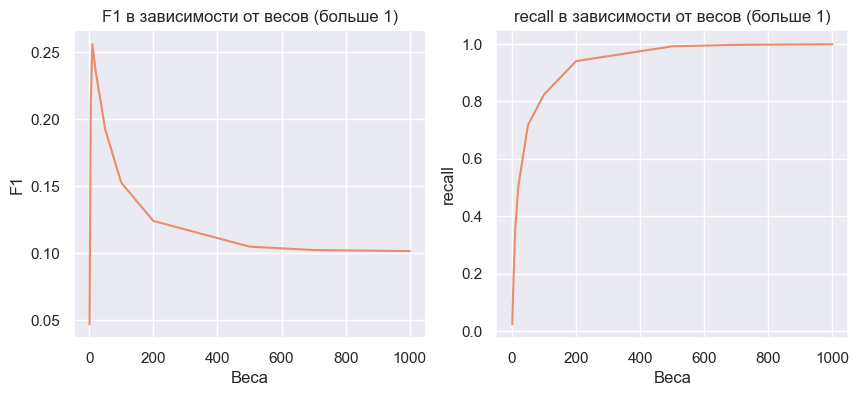

In [ ]:
plt.figure(figsize=(10,4))

plt.subplot(1, 2, 1)
plt.plot([1, 5, 10, 20, 50, 100, 200, 500, 700, 1000], f1)
plt.title('F1 в зависимости от весов (больше 1)')
plt.xlabel('Веса')
plt.ylabel('F1')

plt.subplot(1, 2, 2)
plt.plot([1, 5, 10, 20, 50, 100, 200, 500, 700, 1000], rec)
plt.title('recall в зависимости от весов (больше 1)')
plt.xlabel('Веса')
plt.ylabel('recall');

In [61]:
print(f'Лучший F1 {max(f1)} с весом {[1, 5, 10, 20, 50, 100, 200, 500, 700, 1000][f1.index(max(f1))]}')

Лучший F1 0.25576995838062805 с весом 10


In [62]:
print(f'Лучший recall {max(rec)} с весом {[1, 5, 10, 20, 50, 100, 200, 500, 700, 1000][rec.index(max(rec))]}')

Лучший recall 0.9989701338825953 с весом 1000


In [ ]:
f1 = []
rec = []
for weight in np.arange(0.1, 1.1, 0.1):
    weights = np.where(opt_y_train == 0, 1, weight)
    cat.fit(opt_x_train, opt_y_train, sample_weight=weights, verbose=False)
    y_preds = cat.predict(opt_x_val)
    f1.append(f1_score(opt_y_val, y_preds))
    rec.append(recall_score(opt_y_val, y_preds))

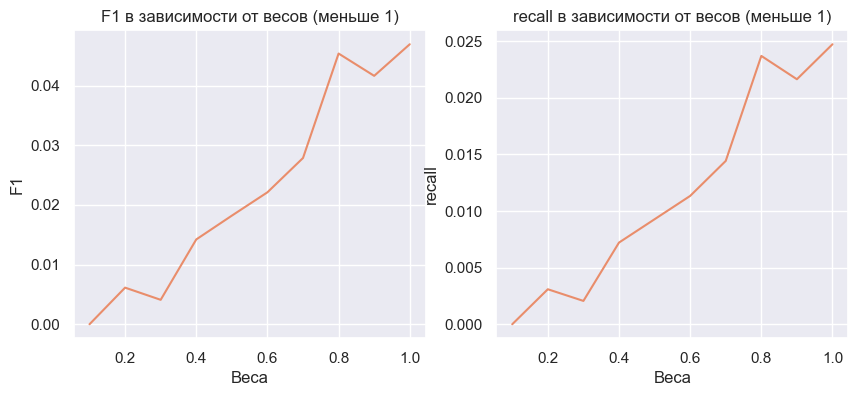

In [ ]:
plt.figure(figsize=(10,4))

plt.subplot(1, 2, 1)
plt.plot(np.arange(0.1, 1.1, 0.1), f1)
plt.title('F1 в зависимости от весов (меньше 1)')
plt.xlabel('Веса')
plt.ylabel('F1')

plt.subplot(1, 2, 2)
plt.plot(np.arange(0.1, 1.1, 0.1), rec)
plt.title('recall в зависимости от весов (меньше 1)')
plt.xlabel('Веса')
plt.ylabel('recall');

In [75]:
print(f'Лучший F1 {max(f1)} с весом {np.arange(0.1, 1.1, 0.1)[f1.index(max(f1))]}')

Лучший F1 0.0469208211143695 с весом 1.0


In [76]:
print(f'Лучший recall {max(rec)} с весом {np.arange(0.1, 1.1, 0.1)[rec.index(max(rec))]}')

Лучший recall 0.024716786817713696 с весом 1.0


**Взвешиваем по 10**

In [99]:
cat = CatBoostClassifier(verbose=False)
weights = np.where(y_train == 0, 1, 10)
cat.fit(x_tr, y_train, sample_weight=weights)
res = metrics(x_ts, cat)
for metric in res:
    final[metric].append(res[metric])

print(f'ROC-AUC: {res['ROC-AUC']}')
print(f'Precision: {res['Precision']}')
print(f'Recall: {res['Recall']}')
print(f'F1: {res['F1']}')
print(f'Cohen Kappa score = {res['Cohen Kappa score']}')
print(f'Matthews coef = {res['Matthews coef']}')

ROC-AUC: 0.7656090507721174
Precision: 0.1977022498803255
Recall: 0.3704035874439462
F1: 0.25780274656679153
Cohen Kappa score = 0.20127776567080902
Matthews coef = 0.21299832297391139


**Взвешиваем по 1000**

In [100]:
cat = CatBoostClassifier(verbose=False)
weights = np.where(y_train == 0, 1, 1000)
cat.fit(x_tr, y_train, sample_weight=weights)
res = metrics(x_ts, cat)
for metric in res:
    final[metric].append(res[metric])

print(f'ROC-AUC: {res['ROC-AUC']}')
print(f'Precision: {res['Precision']}')
print(f'Recall: {res['Recall']}')
print(f'F1: {res['F1']}')
print(f'Cohen Kappa score = {res['Cohen Kappa score']}')
print(f'Matthews coef = {res['Matthews coef']}')

ROC-AUC: 0.7583045034607386
Precision: 0.05556941188207712
Recall: 0.9991031390134529
F1: 0.10528305453170778
Cohen Kappa score = 0.0027416980731179708
Matthews coef = 0.03635944861420174


**Взвешиваем по 500**

In [101]:
cat = CatBoostClassifier(verbose=False)
weights = np.where(y_train == 0, 1, 500)
cat.fit(x_tr, y_train, sample_weight=weights)
res = metrics(x_ts, cat)
for metric in res:
    final[metric].append(res[metric])

print(f'ROC-AUC: {res['ROC-AUC']}')
print(f'Precision: {res['Precision']}')
print(f'Recall: {res['Recall']}')
print(f'F1: {res['F1']}')
print(f'Cohen Kappa score = {res['Cohen Kappa score']}')
print(f'Matthews coef = {res['Matthews coef']}')

ROC-AUC: 0.7524824770534215
Precision: 0.05771035345636534
Recall: 0.9928251121076234
F1: 0.10908015962950189
Cohen Kappa score = 0.007243670840031413
Matthews coef = 0.056950031649575746


## Итоги

In [102]:
models = ['logreg (box)', 
          'logreg, GS(F1)', 
          'logreg, GS(recall)', 
          'cat (box)', 
          'cat, optuna(F1)', 
          'cat, optuna(recall)',
          'cat, PCA(100)',
          'cat, PCA(50)',
          'cat, undersampling (NM)',
          'cat, undersampling (CC)',
          'cat, oversampling (SMOTE, box)',
          'cat, oversampling (SMOTE, 0.5)',
          'cat, oversampling (SMOTE, 0.1)',
          'cat, oversampling (KM-SMOTE)',
          'cat, oversampling (ADASYN)',
          'cat, weights (10)',
          'cat, weights (1000)',
          'cat, weights (500)']
pivot = pd.DataFrame(final, index=models)
pivot

,ROC-AUC,Precision,Recall,F1,Cohen Kappa score,Matthews coef
logreg (box),0.756253,0.390244,0.014350,0.027682,0.023924,0.066315
"logreg, GS(F1)",0.756027,0.404762,0.015247,0.029386,0.025547,0.070020
"logreg, GS(recall)",0.756686,0.357143,0.013453,0.025929,0.022076,0.060507
cat (box),0.775880,0.509434,0.024215,0.046233,0.041512,0.102175
"cat, optuna(F1)",0.740665,0.295019,0.069058,0.111919,0.093250,0.120542
"cat, optuna(recall)",0.654949,0.208333,0.071749,0.106738,0.081190,0.093851
"cat, PCA(100)",0.758076,0.392857,0.009865,0.019248,0.016633,0.055211
"cat, PCA(50)",0.746524,0.324324,0.010762,0.020833,0.017408,0.050632
"cat, undersampling (NM)",0.648021,0.067043,0.841256,0.124189,0.026303,0.082369
"cat, undersampling (CC)",0.721992,0.093923,0.762332,0.167241,0.078157,0.155297


In [112]:
pivot.sort_values(by='Recall', ascending=False)

,ROC-AUC,Precision,Recall,F1,Cohen Kappa score,Matthews coef
"cat, weights (1000)",0.758305,0.055569,0.999103,0.105283,0.002742,0.036359
"cat, weights (500)",0.752482,0.057710,0.992825,0.109080,0.007244,0.056950
"cat, undersampling (NM)",0.648021,0.067043,0.841256,0.124189,0.026303,0.082369
"cat, undersampling (CC)",0.721992,0.093923,0.762332,0.167241,0.078157,0.155297
"cat, weights (10)",0.765609,0.197702,0.370404,0.257803,0.201278,0.212998
"cat, optuna(recall)",0.654949,0.208333,0.071749,0.106738,0.081190,0.093851
"cat, optuna(F1)",0.740665,0.295019,0.069058,0.111919,0.093250,0.120542
cat (box),0.775880,0.509434,0.024215,0.046233,0.041512,0.102175
"cat, oversampling (ADASYN)",0.769751,0.465517,0.024215,0.046036,0.040888,0.096585
"cat, oversampling (SMOTE, 0.1)",0.775022,0.500000,0.022422,0.042918,0.038439,0.097177
